In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [3]:
W[2]

array([6, 7, 8])

In [4]:
W[5]

array([15, 16, 17])

In [5]:
idx = np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

## 입력층의 원핫 표현과 가중치 행렬 W_in의 곱 계산: MatMul을 Embedding 계층으로 전환

In [6]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
  
  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx] # idx 뽑아내기
    return out
  
  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    dW[self.idx] = dout # 실은 나쁜 예(W와 같은 크기의 행렬인 dW를 굳이 따로 만들 필요가 없어서?)
    return None

In [7]:
A = [np.zeros((7,3))]
W1 = A
W2, = A
print("{}, type: {}".format(A, type(A)))
print("{}, type: {}".format(W1, type(W1)))
print("{}, type: {}".format(W2, type(W2)))

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])], type: <class 'list'>
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])], type: <class 'list'>
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], type: <class 'numpy.ndarray'>


In [8]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
  
  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx] # idx 뽑아내기
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0

    # for i, word_id in enumerate(self.idx): # idx에서의 중복 문제를 해결하기 위해서는
    #   dW[word_id] += dout[i] # '할당'이 아닌 '더하기'로 처리.
  
    # 혹은
    np.add.at(dW, self.idx, dout)
    return None

## 은닉층과 가중치 행렬 W_out의 곱 및 Softmax 계층의 계산: Embedding Dot, Negative Sampling



Q: Embedding Dot는 cosine유사도를 구하는 것처럼 |x|*|y|로 나누지 않음. -> Scale을 -무한대부터 +무한대까지 가져가려고?

In [9]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None
  
  def forward(self, h, idx):    # h: 은닉층 뉴런, idx: 단어 ID의 넘파이 배열
    target_W = self.embed.forward(idx) # Embedding class에서 forward 호출 -> target 뽑아냄
    out = np.sum(target_W * h, axis=1) # 내적한 결과를 더함(그림 4-14 참고)

    self.cache = (h, target_W)         # cache로 h와 target_W 남겨둠
    return out
  
  def backward(self, dout):     # 주석 달면서 이해해보기...!
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1) # (3, )인 dout에 (3, 1)로 바꿔 h와 연산 가능하게 함.

    dtarget_W = dout * h          # 곱셈 연산. 
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

In [10]:
import numpy as np
dout = np.array([5, 122, 86])
print("dout: {}, shape of dout: {}".format(dout, dout.shape))
dout = dout.reshape(dout.shape[0],1)
print("dout: {}, shape of dout: {}".format(dout, dout.shape))
h = np.array([[0, 1, 2],
     [3, 4, 5],
     [6, 7, 8]])
print("h: {}, shape of h: {}".format(h, h.shape))
dtarget_W = dout * h
print(dtarget_W)

dout: [  5 122  86], shape of dout: (3,)
dout: [[  5]
 [122]
 [ 86]], shape of dout: (3, 1)
h: [[0 1 2]
 [3 4 5]
 [6 7 8]], shape of h: (3, 3)
[[  0   5  10]
 [366 488 610]
 [516 602 688]]


In [11]:
import numpy as np

words = ['you','say','goodbye','I','hello', '.']
print(np.random.choice(words)) # words에서 하나만 무작위로 샘플링
print(np.random.choice(words, size=5)) # 5개만 무작위로 샘플링(중복 있음)
print(np.random.choice(words, size=5, replace=False)) # 5개만 무작위로 샘플링(중복 없음)
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1] 
print(np.random.choice(words, p=p)) # 확률분포에 따라 샘플링

say
['say' 'I' 'you' 'hello' 'hello']
['goodbye' 'hello' 'say' 'I' '.']
hello


In [12]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [13]:
import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')

from ch04.negative_sampling_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 2]
 [1 4]
 [3 1]]


In [14]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
      self.sample_size = sample_size
      self.sampler = UnigramSampler(corpus, power, sample_size)
      self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
      self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
      self.params, self.grads = [], []
      for layer in self.embed_dot_layers:
        self.params += layer.params
        self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)

    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)

    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype=np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)

    return loss

  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)

    return dh 

In [15]:
import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')

    # 계층 생성
    self.in_layers = []
    for i in range(2 * window_size):
      layer = Embedding(W_in)
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

    # 모든 가중치와 기울기를 배열에 모은다.
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
    
    # 인스턴스 변수에 단어의 분산 표현을 저장.
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
  
  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 7[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 11[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 12[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.15
| 에폭 1 |  반복 241 / 9295 | 시간 15[s] | 손실 3.07
| 에폭 1 |  반복 261 / 9295 | 시간 16[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.93
| 에폭 1 |  반복 301 / 9295 | 시간 19[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 20[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 21[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 23[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 24[s] | 손실 2.78
| 에폭 1 |  반복 401 / 9295 | 시간 25[s] | 손실 2.74
| 에폭 1 |  반복 421 / 9295 | 시간 27[s] | 손실 2.76
| 에폭 1 |  반복 441 / 9295 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

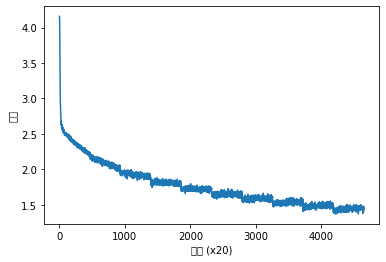

In [ ]:
import sys 
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(쿠파이 필요).
# ======================================================
# config.GPU = True
# ======================================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)


In [18]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  13859      0 --:--:-- --:--:-- --:--:-- 13859
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 369.7MB 42kB/s 
+ set +ex
Installation succeeded!


In [19]:
import sys 
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(쿠파이 필요).
# ======================================================
config.GPU = True
# ======================================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)


ValueError: ignored

In [ ]:
import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7412109375
 i: 0.69921875
 they: 0.63330078125
 your: 0.62548828125
 anybody: 0.59814453125

[query] year
 month: 0.8662109375
 week: 0.80517578125
 summer: 0.7607421875
 spring: 0.7353515625
 decade: 0.6748046875

[query] car
 truck: 0.6337890625
 cars: 0.5869140625
 window: 0.58251953125
 auto: 0.57958984375
 luxury: 0.53515625

[query] toyota
 nissan: 0.66943359375
 minicomputers: 0.66064453125
 chevrolet: 0.6494140625
 seita: 0.63623046875
 cars: 0.62939453125


## Skip-gram

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.layers import *
from ch04.negative_sampling_layer import NegativeSamplingLoss


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

In [ ]:
import sys 
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(쿠파이 필요).
# ======================================================
# config.GPU = True
# ======================================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)


In [ ]:
import sys
sys.path.append('/content/drive/Shareddrives/KU-BIG_2021-1_NLP_Study/input')
from common.util import most_similar
import pickle

pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)